# Data Exploration

## TODO

- Make visualizations using `train_tweets` data frame

In [1]:
# global imports
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
from pyspark.sql.types import StringType, IntegerType, ArrayType
import numpy as np
# vectors
from pyspark.ml.linalg import Vectors
# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# clustering algorithm
from pyspark.ml.clustering import LDA

spark = SparkSession.builder.getOrCreate()

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
# import train_tweets data
train_tweets = spark.createDataFrame(dfs[2])
# output dataframe
train_tweets.show(2)

+--------+--------------+----------+-------------+--------------------+
|   label|negativereason|   airline|retweet_count|                text|
+--------+--------------+----------+-------------+--------------------+
|negative|    Bad Flight|US Airways|            0|@USAirways yes.  ...|
|positive|          null|     Delta|            0|Sigh... “@JetBlue...|
+--------+--------------+----------+-------------+--------------------+
only showing top 2 rows



In [4]:
# import train data
train = spark.createDataFrame(dfs[0])
# output dataframe
train.show(2)

+--------------------+---------+
|           count_vec|label_idx|
+--------------------+---------+
|(349,[0,2,16,22,4...|      0.0|
|(349,[5,7,8,158,1...|      1.0|
+--------------------+---------+
only showing top 2 rows



In [5]:
# import test data
test = spark.createDataFrame(dfs[1])
# output data frame
test.show(2)

+--------------------+---------+
|           count_vec|label_idx|
+--------------------+---------+
|(349,[2,58,118,12...|      0.0|
|(349,[0,4,134,186...|      1.0|
+--------------------+---------+
only showing top 2 rows



In [6]:
# import vocabulary
vocab = dfs[3]

# Variable Distributions

In [7]:
# summary statistics for retweet_count
train_tweets.describe('retweet_count').show()

+-------+-------------------+
|summary|      retweet_count|
+-------+-------------------+
|  count|              10223|
|   mean|0.08793896116599824|
| stddev| 0.7559807111560248|
|    min|                  0|
|    max|                 32|
+-------+-------------------+



In [8]:
# counts for each level of categorical variables
cat_vars = ['label','negativereason','airline']
for var in cat_vars:
    train_tweets.groupby(var).count().show()

+--------+-----+
|   label|count|
+--------+-----+
|positive| 3852|
|negative| 6371|
+--------+-----+

+--------------------+-----+
|      negativereason|count|
+--------------------+-----+
|        Lost Luggage|  473|
|           longlines|  121|
|         Late Flight| 1175|
|                null| 3852|
|     Damaged Luggage|   48|
|    Cancelled Flight|  607|
|Customer Service ...| 1992|
|Flight Attendant ...|  340|
|          Bad Flight|  412|
|          Can't Tell|  830|
|Flight Booking Pr...|  373|
+--------------------+-----+

+--------------+-----+
|       airline|count|
+--------------+-----+
|         Delta| 1560|
|Virgin America|  356|
|        United| 2669|
|    US Airways| 2034|
|     Southwest| 1698|
|      American| 1906|
+--------------+-----+



## Most Common Words

In [9]:
# 20 most common words
for i in range(0,20):
    print(vocab[i])

flight
united
usairways
americanair
southwestair
jetblue
get
co
http
hour
two
thanks
cancelled
service
time
customer
one
help
bag
plane


# Data Visualization

## Word Counts

In [10]:
# function for creating key and value pair of a row
def key_val(row):
    new_row = [(i,row[i]) for i in range(len(row))]
    return new_row

In [11]:
# create dictionary of indices and word counts
word_counts_dict = train.select('count_vec').rdd\
                   .map(lambda row: row.count_vec.toArray())\
                   .map(lambda row: key_val(row))\
                   .flatMap(lambda row: row)\
                   .reduceByKey(lambda x,y: x+y)\
                   .mapValues(lambda x: int(x))\
                   .collectAsMap()

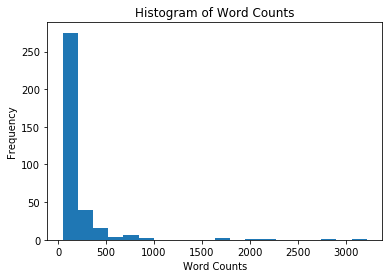

In [12]:
# obtain word counts
word_counts = list(word_counts_dict.values())
# create a histogram of word counts
plt.hist(word_counts,bins=20)
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')
plt.show()

## `text` Variable

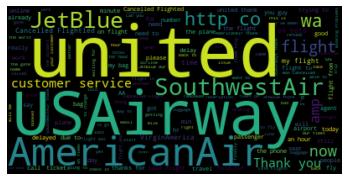

In [13]:
# create an RDD of the tweets
tweets_lst = train_tweets.select('text').rdd.flatMap(lambda row:row).collect()
# create a string of all of the tweets
tweets = ''
for tweet in tweets_lst:
    tweets += tweet
# create a word cloud
wordcloud = WordCloud().generate(tweets)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Positive and Negative Tweets by Airline

In [14]:
# create data frame of counts for airline and label
airline = train_tweets.groupby('label','airline').count()
# output data frame
airline.show()

+--------+--------------+-----+
|   label|       airline|count|
+--------+--------------+-----+
|positive|     Southwest|  873|
|negative|      American| 1342|
|negative|     Southwest|  825|
|positive|        United|  839|
|positive|      American|  564|
|negative|         Delta|  665|
|positive|         Delta|  895|
|negative|    US Airways| 1585|
|positive|Virgin America|  232|
|positive|    US Airways|  449|
|negative|Virgin America|  124|
|negative|        United| 1830|
+--------+--------------+-----+



In [15]:
# create data frame for counts of positive tweets
pos_airline = airline.where(W.col('label') == 'positive').sort('airline')
pos_airline = pos_airline.withColumnRenamed('count','pos_count')
pos_airline.show()

+--------+--------------+---------+
|   label|       airline|pos_count|
+--------+--------------+---------+
|positive|      American|      564|
|positive|         Delta|      895|
|positive|     Southwest|      873|
|positive|    US Airways|      449|
|positive|        United|      839|
|positive|Virgin America|      232|
+--------+--------------+---------+



In [16]:
# create data frame for counts of negative tweets
neg_airline = airline.where(W.col('label') == 'negative').sort('airline')
neg_airline = neg_airline.withColumnRenamed('count','neg_count')
neg_airline = neg_airline.withColumnRenamed('airline','airline2')
neg_airline.show()

+--------+--------------+---------+
|   label|      airline2|neg_count|
+--------+--------------+---------+
|negative|      American|     1342|
|negative|         Delta|      665|
|negative|     Southwest|      825|
|negative|    US Airways|     1585|
|negative|        United|     1830|
|negative|Virgin America|      124|
+--------+--------------+---------+



In [17]:
# create data frame for proportions
prop_airline = pos_airline.join(neg_airline,(pos_airline.airline==neg_airline.airline2))
prop_airline = prop_airline.withColumn('count',W.col('pos_count')+W.col('neg_count'))
prop_airline = prop_airline.withColumn('pos_prop',W.col('pos_count')/W.col('count'))
prop_airline = prop_airline.withColumn('neg_prop',W.col('neg_count')/W.col('count'))
prop_airline.show()

+--------+--------------+---------+--------+--------------+---------+-----+-------------------+-------------------+
|   label|       airline|pos_count|   label|      airline2|neg_count|count|           pos_prop|           neg_prop|
+--------+--------------+---------+--------+--------------+---------+-----+-------------------+-------------------+
|positive|         Delta|      895|negative|         Delta|      665| 1560| 0.5737179487179487|0.42628205128205127|
|positive|Virgin America|      232|negative|Virgin America|      124|  356|  0.651685393258427|0.34831460674157305|
|positive|        United|      839|negative|        United|     1830| 2669|0.31434994379917575| 0.6856500562008243|
|positive|    US Airways|      449|negative|    US Airways|     1585| 2034| 0.2207472959685349| 0.7792527040314651|
|positive|     Southwest|      873|negative|     Southwest|      825| 1698| 0.5141342756183745|0.48586572438162545|
|positive|      American|      564|negative|      American|     1342| 19

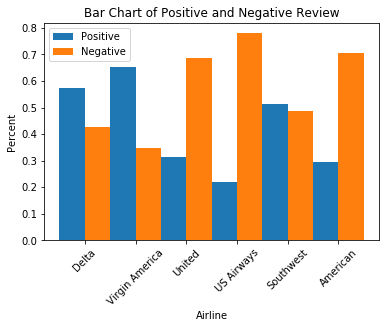

In [18]:
# create bar chart for proportions of positive and negative airline tweets
labels = prop_airline.select('airline').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
plt.bar(x-0.5/2,prop_airline.select('pos_prop').rdd.map(lambda row:row[0]).collect(),width=0.5)
plt.bar(x+0.5/2,prop_airline.select('neg_prop').rdd.map(lambda row:row[0]).collect(),width=0.5)
plt.xticks(x,labels, rotation='45')
plt.xlabel('Airline')
plt.ylabel('Percent')
plt.title('Bar Chart of Positive and Negative Review')
plt.legend(['Positive','Negative'])
plt.show()

# Latent Dirichlet Allocation

## Tune Number of Topics

In [19]:
# FIRST ITERATION
# number of topics to try
ks1 = [5,10,15,20]
log_likelihoods1 = []
# obtain log likelihoods of the LDA for each number of topics
for k in ks1:
    lda_k1 = LDA(featuresCol='count_vec').setK(k).setSeed(414)
    lda_model_k1 = lda_k1.fit(train)
    log_likelihoods1.append(lda_model_k1.logLikelihood(test))

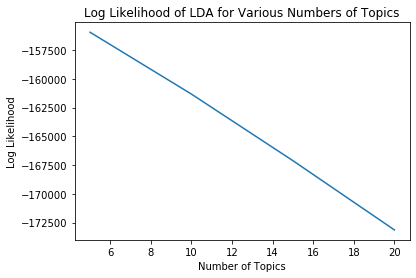

In [20]:
# plot the log likelihood for each number of topics
plt.plot(ks1,log_likelihoods1)
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of LDA for Various Numbers of Topics')
plt.show()

In [21]:
# SECOND ITERATION
# number of topics to try
ks2 = [2,3,4,5,6,7,8,9]
log_likelihoods2 = []
# obtain log likelihoods of the LDA for teach number of topics
for k in ks2:
    lda_k2 = LDA(featuresCol='count_vec').setK(k).setSeed(414)
    lda_model_k2 = lda_k2.fit(train)
    log_likelihoods2.append(lda_model_k2.logLikelihood(test))

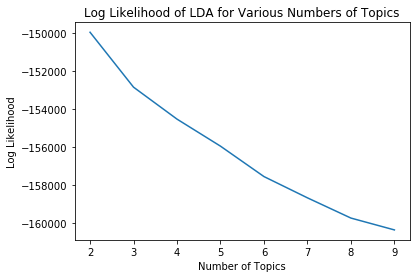

In [22]:
# plot the log likelihood for each number of topics
plt.plot(ks2,log_likelihoods2)
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of LDA for Various Numbers of Topics')
plt.show()

## Final Clustering Model

In [23]:
# create final LDA model
lda2 = LDA(featuresCol='count_vec',k=2).setSeed(968)
lda_model2 = lda2.fit(train)
lda_model2.logLikelihood(train)

-348940.04652139836

In [24]:
# obtain topic distribition for each row of the train dataframe
train_topics2 = lda_model2.transform(train)
train_topics2.select('topicDistribution').show(5,truncate=False)

+----------------------------------------+
|topicDistribution                       |
+----------------------------------------+
|[0.6762492095311904,0.32375079046880956]|
|[0.10417990010047716,0.8958200998995228]|
|[0.8714111887348377,0.12858881126516236]|
|[0.2619177526102186,0.7380822473897813] |
|[0.40293592008975826,0.5970640799102418]|
+----------------------------------------+
only showing top 5 rows



In [25]:
# obtain term indices for each topic
topics2 = lda_model2.describeTopics(300)
topics2.show(2)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1, 4, 0, 6, 5, 3...|[0.06079123448454...|
|    1|[0, 2, 3, 5, 7, 8...|[0.06302179205838...|
+-----+--------------------+--------------------+



In [26]:
# function for converting index to word
def index_to_word(row):
    new_row = []
    for item in row:
        new_row.append(vocab[item])
    return new_row
# udf for converting index to word
index_to_word_udf = W.udf(lambda row: index_to_word(row), ArrayType(StringType()))
# add column of words corresponding to each index
topics2 = topics2.withColumn('topic_words', index_to_word_udf('termIndices'))
# output dataframe
topics2.show(2)

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|
+-----+--------------------+--------------------+--------------------+
|    0|[1, 4, 0, 6, 5, 3...|[0.06079123448454...|[united, southwes...|
|    1|[0, 2, 3, 5, 7, 8...|[0.06302179205838...|[flight, usairway...|
+-----+--------------------+--------------------+--------------------+



## Word Cloud

In [27]:
# function for whole number of weights (used for word cloud frequencies)
def weights_whole(row):
    weights = []
    for item in row:
        weights.append(int(item*10000))
    return weights
# udf for whole number of weights
weights_whole_udf = W.udf(lambda row: weights_whole(row), ArrayType(IntegerType()))
# add column with whole number of weights
topics2 = topics2.withColumn('weights_whole', weights_whole_udf('termWeights'))
# output dataframe
topics2.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|       weights_whole|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|[1, 4, 0, 6, 5, 3...|[0.06079123448454...|[united, southwes...|[607, 423, 381, 2...|
|    1|[0, 2, 3, 5, 7, 8...|[0.06302179205838...|[flight, usairway...|[630, 523, 472, 3...|
+-----+--------------------+--------------------+--------------------+--------------------+



In [28]:
# function for creating word cloud
def wordcloudplot(lda,topics):
    for k in range(lda.getK()):
        topick = topics.where(W.col('topic') == k)
        topick_dict = {}
        for i,v in zip(topick.select('topic_words').rdd.map(lambda x:x[0]).collect()[0],topick.select('weights_whole').rdd.map(lambda x:x[0]).collect()[0]):
            topick_dict[i] = v
        cloud = WordCloud()
        plt.figure()
        cloud.generate_from_frequencies(topick_dict)
        plt.imshow(cloud)
        plt.axis("off")
        plt.margins(x=0, y=0)
        plt.show()

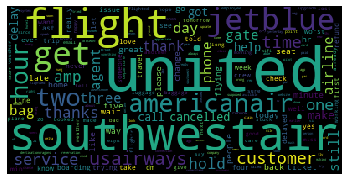

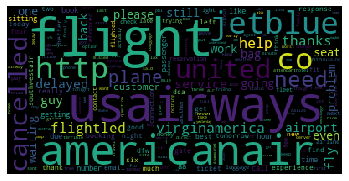

In [29]:
# create word cloud for each topic
wordcloudplot(lda2,topics2)

## Try Different Number of Topics

We don't think splitting the data into two topics is adequate

In [30]:
# create final LDA model
lda = LDA(featuresCol='count_vec',k=8).setSeed(968)
lda_model = lda.fit(train)
lda_model.logLikelihood(train)

-363215.33365414967

In [31]:
# obtain term indices for each topic
topics = lda_model.describeTopics(300)
topics.show(2)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1, 4, 5, 0, 15, ...|[0.08099935762425...|
|    1|[7, 8, 3, 1, 5, 0...|[0.08482887149333...|
+-----+--------------------+--------------------+
only showing top 2 rows



In [32]:
# add column of words corresponding to each index
topics = topics.withColumn('topic_words', index_to_word_udf('termIndices'))
# output dataframe
topics.show(2)

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|
+-----+--------------------+--------------------+--------------------+
|    0|[1, 4, 5, 0, 15, ...|[0.08099935762425...|[united, southwes...|
|    1|[7, 8, 3, 1, 5, 0...|[0.08482887149333...|[co, http, americ...|
+-----+--------------------+--------------------+--------------------+
only showing top 2 rows



In [33]:
# add column with whole number of weights
topics = topics.withColumn('weights_whole', weights_whole_udf('termWeights'))
# output dataframe
topics.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|       weights_whole|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|[1, 4, 5, 0, 15, ...|[0.08099935762425...|[united, southwes...|[809, 341, 242, 2...|
|    1|[7, 8, 3, 1, 5, 0...|[0.08482887149333...|[co, http, americ...|[848, 846, 553, 3...|
+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



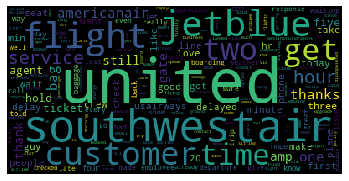

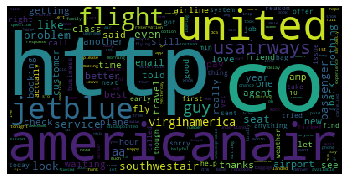

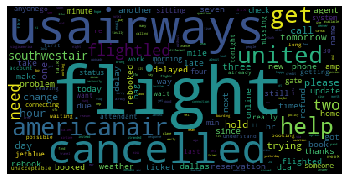

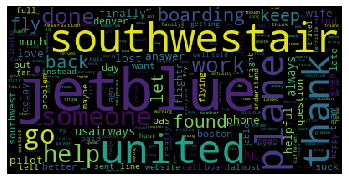

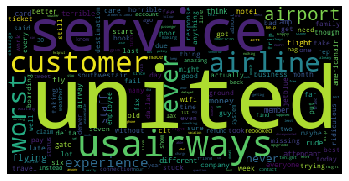

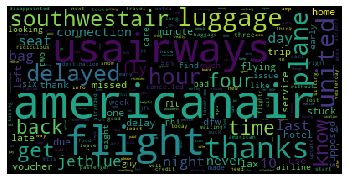

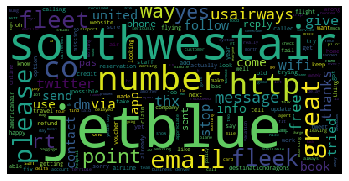

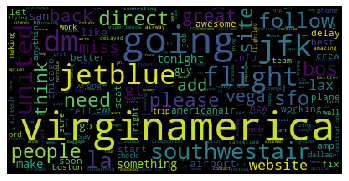

In [34]:
# create word cloud for each topic
wordcloudplot(lda,topics)